# PHYS-GA2059 - Statistics and Data Science for Physicists
# Student: Gehan Ranepura
## Problem Set #5

In [49]:
import sys
import corner
import pandas as pd
import numpy as np
import ipywidgets as widgets
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import pylab as pyplt
import random
import scipy as sci

from numpy.linalg import inv
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from numpy import random
from matplotlib import patches
from matplotlib.colors import LogNorm,Normalize
from pylab import gca, cm
from scipy import linalg
from scipy import stats
from scipy.linalg import *
from scipy.optimize import minimize
from scipy.stats import norm, invgamma, multivariate_normal

## Problem 1: 
Take the Gaia XP data given to you by Jiadong Li. 
- It consists of a set of ESA Gaia Mission BP/RP spectral coefficients, and a set of labels from SDSS-IV APOGEE.
- These are real data, people, and a real problem. 

Use linear regression to learn a function that takes as input the BP and RP spectral coefficients and delivers as output the label TEFF, which is the effective temperature of the stars. 

Instead of using the BP/RP coefficients right out of the box, consider dividing all BP & RP coefficients by the first (zeroth) component of the RP coefficients. 
- Don’t forget to include the number 1 as a regressor (the constant term). 
- Train on the training set and use the validation set to assess your accuracy (RMS maybe or median absolute deviation). Ask questions of Hogg and Jiadong, who know these data well!

In [50]:
# Open up training and validation datasets from Jiadong's pickle files
with open("ap17_xpcont_train.pickle", 'rb') as d1:
    data_tr = pkl.load(d1)

with open("ap17_xpcont_validation.pickle", 'rb') as d2:
    data_val = pkl.load(d2)

# Both of these data sets contain keys for: BP coeff, RP coeff and 2 labels ( T_eff and log (g) )
 
print("Keys of training set and validation set:")
print(data_tr.keys(), "\n", data_val.keys(), "\n")

print("Dimensions of training set and validation set:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])

Keys of training set and validation set:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels']) 

Dimensions of training set and validation set:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]


### <center> There are 4000 training datapoints and 1000 validation datapoints <center>
### <center> Each datapoint contains 55 RP coeff, 55 BP coeff and the 2 labels ( T_eff and log (g) ) <center> 

In [70]:
# Instead of using the BP/RP coefficients right out of the box, 
# consider dividing all BP & RP coefficients by the first (zeroth) component of the RP coefficients. 

# TRAINING DATA:
max_RP_train = np.max(data_tr['rp_coef'])          # Find first component of the RP coeff
X_BP_train   = data_tr['bp_coef']/max_RP_train     # Divide BP and RP coeff by the first RP coeff component
X_RP_train   = data_tr['rp_coef']/max_RP_train
X_data_train = np.dstack((X_BP_train, X_RP_train)) # X_data_train has shape (4000, 55, 2) = BP and RP
Y_data_train = data_tr['labels'][:,0]              # Y_data_train has shape (4000, 1) = T_eff
print(X_data_train.shape, Y_data_train.shape)

# VALIDATION DATA:
max_RP_val = np.max(data_val['rp_coef'])           # Find first component of the RP coeff
X_BP_val   = data_val['bp_coef']/max_RP_val        # Divide BP and RP coeff by the first RP coeff component
X_RP_val   = data_val['rp_coef']/max_RP_val
X_data_val = np.dstack((X_BP_val, X_RP_val))       # X_data_val has shape (1000, 55, 2) = BP and RP
Y_data_val = data_val['labels'][:,0]               # Y_data_val has shape (1000,1) = T_eff
print(X_data_val.shape, Y_data_val.shape)

(4000, 55, 2) (4000,)
(1000, 55, 2) (1000,)


## A linear regression model can be determined by minimizing the loss function,

$$ 
\begin{align}
\lVert Y - X\Theta \rVert^2_2 +\Lambda \lVert \Theta \rVert^2_2 \\
\end{align}
$$

where, $\Lambda$ in the second term called the "Ridge" can be tuned to perform a better predicition. 

The solution is,

$$ 
\begin{align}
\hat{\Theta} = \left( X^T X + \Lambda I \right)^{-1} X^T Y 
\end{align}
$$


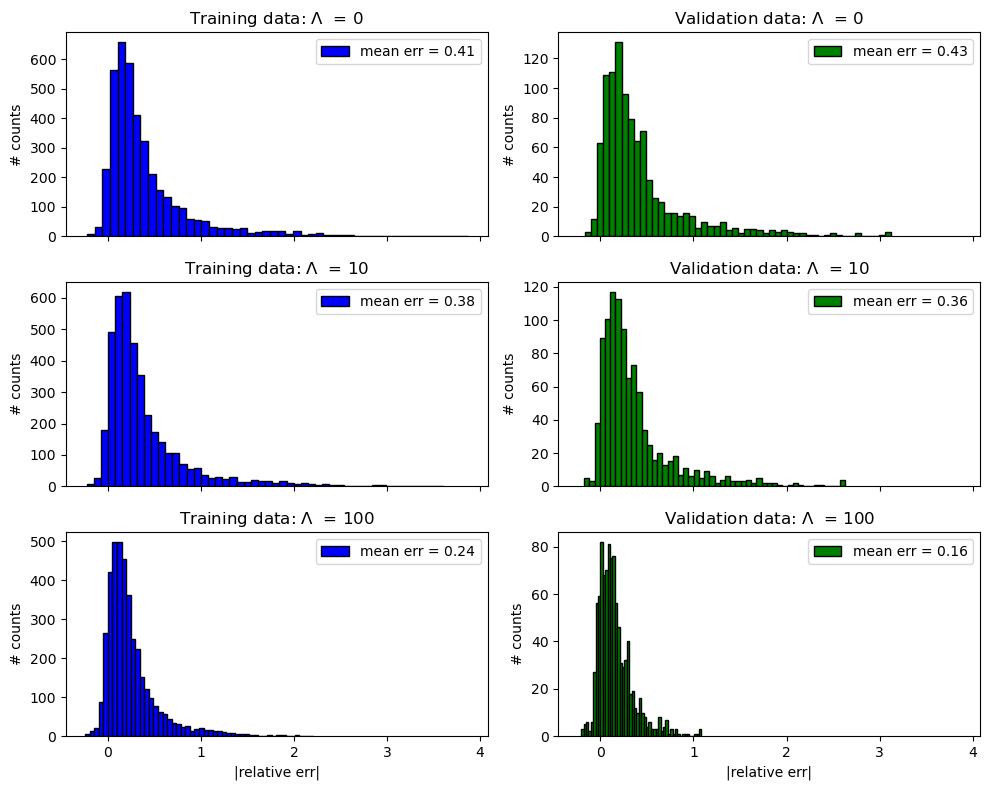

In [103]:
# Define a function to solve for theta
def solve_theta(X_data, Y_data, Lambda): # If Lambda = 0, there is no Ridge
    # Add ones column to X_data
    X_data  = np.stack((X_data, np.ones(X_data.shape)), axis = 3) # shape is           (4000, 55, 2, 2)
    Xt_data = np.transpose(X_data)                                # transpose shape is (2, 2, 55, 4000)
    Y_data  = np.expand_dims(Y_data, 1)                           # new shape is       (1000, 1, 1)
    
    # Let A = X.T X, B = Lamdbda I, D = X.T Y  
    # A + B = C
    # THETA = C^(-1) D
    A = np.tensordot(Xt_data, X_data, ( (3,2,1), (0,1,2)) ) 
    B = Lambda * np.identity(A.shape[0])
    C = A + B
    #D = Xt_data.dot(Y_data)
    D = Xt_data @ Y_data
    theta = linalg.solve(C, D)
    return theta

# Define a function to receive the error assosicated with the Y_data
def solve_Y_err(X_data, Y_data, Lambda): #
    theta  = solve_theta(X_data, Y_data, Lambda)                   
    X_data = np.stack((X_data, np.ones(X_data.shape)), axis = 3)  
    Y_data = Y_data[:, np.newaxis]
    Y_hat  = np.tensordot(X_data, theta, axes=((3,2,1), (0,1,2)))
    Y_err  = ((Y_hat-Y_data)/Y_data).flatten()                   
    return Y_err

# Make Figures for both Training and Validation data for 3 different Lambda values
fig, ax = plt.subplots(3,2, figsize = (10,8), sharex=True)
ax[2,0].set_xlabel('|relative err|')
ax[2,1].set_xlabel('|relative err|')

# first row, first col: training data, Lambda = 0
Y_err = solve_Y_err(X_data_train, Y_data_train, 0)
ax[0,0].hist(Y_err, bins = 50, color = "blue", ec="black", \
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,0].legend()
ax[0,0].set_title(r'Training data: $\Lambda$  = 0')
ax[0,0].set_ylabel('# counts')

# second row, first col: training data, Lambda = 10
Y_err = solve_Y_err(X_data_train, Y_data_train, 10)
ax[1,0].hist(Y_err, bins = 50, color = "blue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,0].legend()
ax[1,0].set_title(r'Training data: $\Lambda$  = 10')
ax[1,0].set_ylabel('# counts')

# third row, first col: training data, Lambda = 100
Y_err = solve_Y_err(X_data_train, Y_data_train, 100)
ax[2,0].hist(Y_err, bins = 50, color = "blue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,0].legend()
ax[2,0].set_title(r'Training data: $\Lambda$  = 100')
ax[2,0].set_ylabel('# counts')

print("\n")

# first row, second col: validation data, Lambda = 0
Y_err = solve_Y_err(X_data_val, Y_data_val, 0)
ax[0,1].hist(Y_err, bins = 50, color = "green", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,1].legend()
ax[0,1].set_title(r'Validation data: $\Lambda$  = 0')
ax[0,1].set_ylabel('# counts')

# second row, second col: validation data, Lambda = 10
Y_err = solve_Y_err(X_data_val, Y_data_val, 10)
ax[1,1].hist(Y_err, bins = 50, color = "green", ec="black",\
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,1].legend()
ax[1,1].set_title(r'Validation data: $\Lambda$  = 10')
ax[1,1].set_ylabel('# counts')

# third row, second col: validation data, Lambda = 100
Y_err = solve_Y_err(X_data_val, Y_data_val, 100)
ax[2,1].hist(Y_err, bins = 50, color = "green", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,1].legend()
ax[2,1].set_title(r'Validation data: $\Lambda$  = 100')
ax[2,1].set_ylabel('# counts')

plt.tight_layout()

# Problem 2:

Now consider only the RP spectral coefficients. Make a linear model to predict TEFF. 

Then make all quadratic combinations of the RP coefficients and make a linear model of the linear and quadratic combinations to predict TEFF. 
- Can you afford to do cubic too? Once again, divide the coefficients by RP[0] to start. 
- Once again, don’t forget to include the constant term. 
- Train on the training set and use the validation set to assess your accuracy.

In [245]:
# TRAINING DATA:
max_RP_train = np.max(data_tr['rp_coef'])          # Find first component of the RP coeff
X_RP_train   = data_tr['rp_coef']/max_RP_train     # Divide RP coeff by the first RP coeff component
X_data_train = X_RP_train                          # X_data_train has shape (4000, 55) = RP only
Y_data_train = data_tr['labels'][:,0]              # Y_data_train has shape (4000, 1) = T_eff
print(X_data_train.shape, Y_data_train.shape)

# VALIDATION DATA:
max_RP_val = np.max(data_val['rp_coef'])           # Find first component of the RP coeff
X_RP_val   = data_val['rp_coef']/max_RP_val        # Divide BP RP coeff by the first RP coeff component
X_data_val = X_RP_val                              # X_data_val has shape (1000, 55) = RP only
Y_data_val = data_val['labels'][:,0]               # Y_data_val has shape (1000,1) = T_eff
print(X_data_val.shape, Y_data_val.shape)

(4000, 55) (4000,)
(1000, 55) (1000,)


# Solution
## Make a linear model to predict TEFF

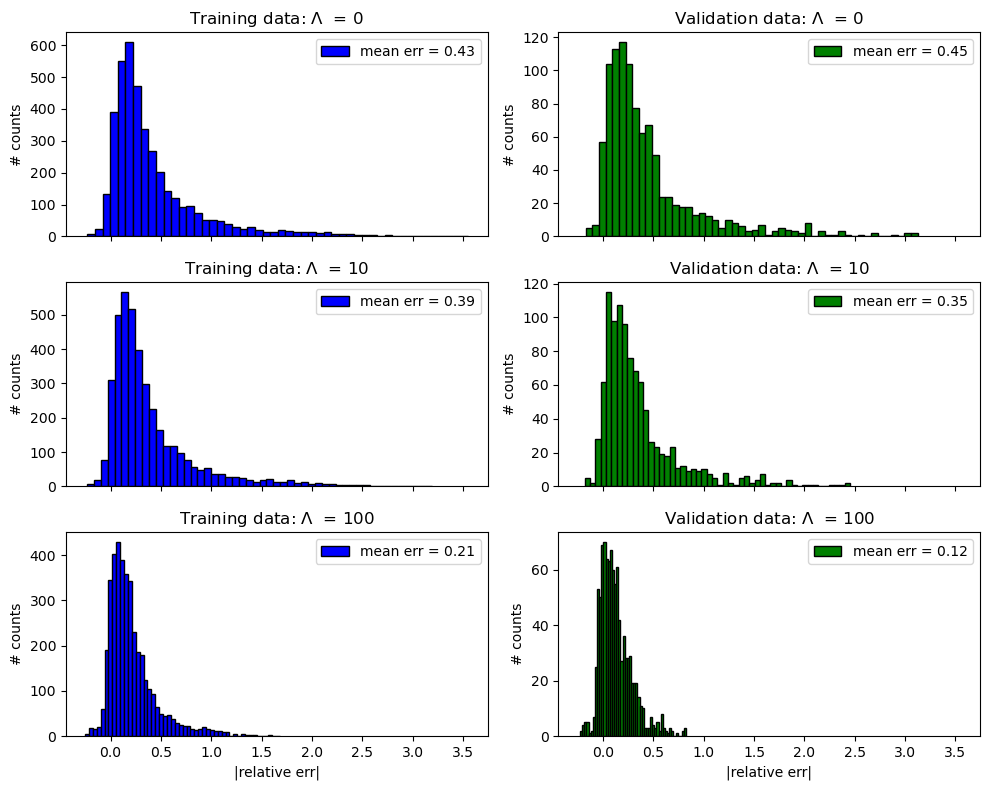

In [109]:
# Define a function to solve for theta
def solve_theta(X_data, Y_data, Lambda): # If Lambda = 0, there is no Ridge
    # Add ones column to X_data
    X_data  = np.stack((X_data, np.ones(X_data.shape)), axis = 2) # shape is           (4000, 55, 2)
    Xt_data = np.transpose(X_data)                                # transpose shape is (2, 2, 55, 4000)
    Y_data  = np.expand_dims(Y_data, 1)                           # new shape is       (1000, 1, 1)
    
    # Let A = X.T X, B = Lamdbda I, D = X.T Y  
    # A + B = C
    # THETA = C^(-1) D
    A = np.tensordot(Xt_data, X_data, ( (2,1), (0,1)) ) 
    B = Lambda * np.identity(A.shape[0])
    C = A + B
    #D = Xt_data.dot(Y_data)
    D = Xt_data @ Y_data
    theta = linalg.solve(C, D)
    return theta

# Define a function to receive the error assosicated with the Y_data
def solve_Y_err(X_data, Y_data, Lambda): #
    theta  = solve_theta(X_data, Y_data, Lambda)                   
    X_data = np.stack((X_data, np.ones(X_data.shape)), axis = 2) 
    Y_data = Y_data[:, np.newaxis]
    Y_hat  = np.tensordot(X_data, theta, axes=((2,1), (0,1)))
    Y_err  = ((Y_hat-Y_data)/Y_data).flatten()                   
    return Y_err

# Make Figures for both Training and Validation data for 3 different Lambda values
fig, ax = plt.subplots(3,2, figsize = (10,8), sharex=True)
ax[2,0].set_xlabel('|relative err|')
ax[2,1].set_xlabel('|relative err|')

# first row, first col: training data, Lambda = 0
Y_err = solve_Y_err(X_data_train, Y_data_train, 0)
ax[0,0].hist(Y_err, bins = 50, color = "blue", ec="black", \
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,0].legend()
ax[0,0].set_title(r'Training data: $\Lambda$  = 0')
ax[0,0].set_ylabel('# counts')

# second row, first col: training data, Lambda = 10
Y_err = solve_Y_err(X_data_train, Y_data_train, 10)
ax[1,0].hist(Y_err, bins = 50, color = "blue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,0].legend()
ax[1,0].set_title(r'Training data: $\Lambda$  = 10')
ax[1,0].set_ylabel('# counts')

# third row, first col: training data, Lambda = 100
Y_err = solve_Y_err(X_data_train, Y_data_train, 100)
ax[2,0].hist(Y_err, bins = 50, color = "blue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,0].legend()
ax[2,0].set_title(r'Training data: $\Lambda$  = 100')
ax[2,0].set_ylabel('# counts')

print("\n")

# first row, second col: validation data, Lambda = 0
Y_err = solve_Y_err(X_data_val, Y_data_val, 0)
ax[0,1].hist(Y_err, bins = 50, color = "green", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,1].legend()
ax[0,1].set_title(r'Validation data: $\Lambda$  = 0')
ax[0,1].set_ylabel('# counts')

# second row, second col: validation data, Lambda = 10
Y_err = solve_Y_err(X_data_val, Y_data_val, 10)
ax[1,1].hist(Y_err, bins = 50, color = "green", ec="black",\
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,1].legend()
ax[1,1].set_title(r'Validation data: $\Lambda$  = 10')
ax[1,1].set_ylabel('# counts')

# third row, second col: validation data, Lambda = 100
Y_err = solve_Y_err(X_data_val, Y_data_val, 100)
ax[2,1].hist(Y_err, bins = 50, color = "green", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,1].legend()
ax[2,1].set_title(r'Validation data: $\Lambda$  = 100')
ax[2,1].set_ylabel('# counts')

plt.tight_layout()

## Make all quadratic combinations of the RP coefficients and make a linear model of the linear and quadratic combinations to predict TEFF. 

/var/folders/zn/wknmd3793w1b08wgws1qx64m0000gp/T/ipykernel_77657/4203813458.py:15: LinAlgWarning: Ill-conditioned matrix (rcond=1.84957e-35): result may not be accurate.
  theta = solve(C, D)


/var/folders/zn/wknmd3793w1b08wgws1qx64m0000gp/T/ipykernel_77657/4203813458.py:15: LinAlgWarning: Ill-conditioned matrix (rcond=2.45341e-34): result may not be accurate.
  theta = solve(C, D)


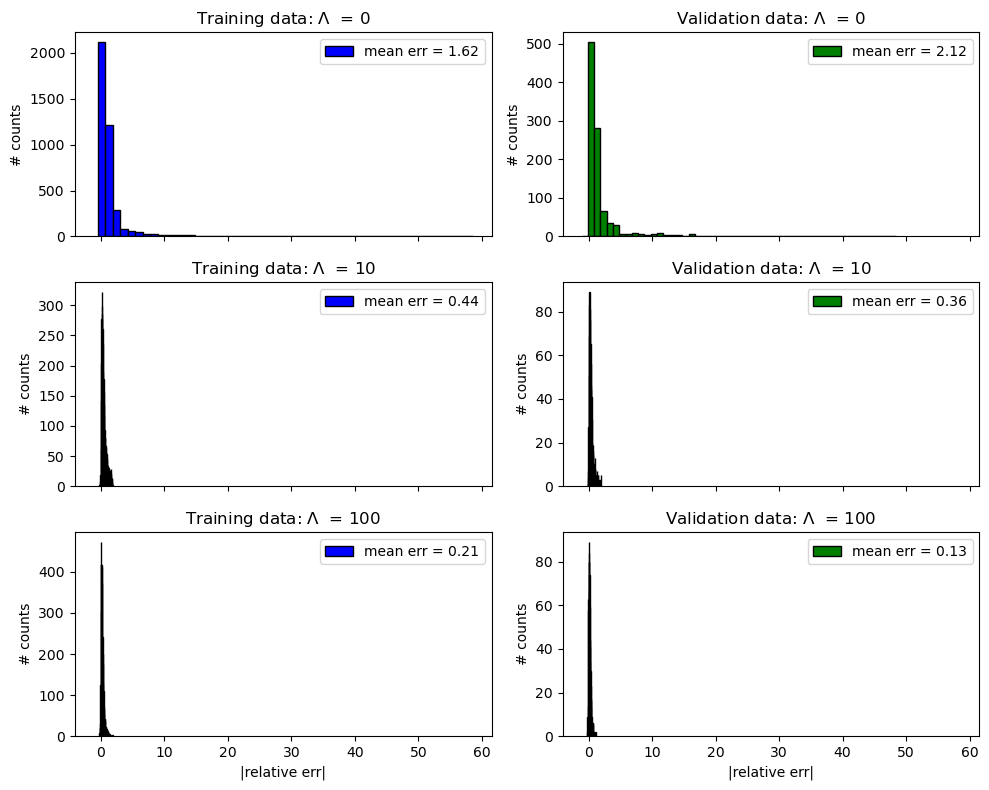

In [121]:
def solve_theta(X_data, Y_data, Lambda): 
    Xsq_data = np.square(X_data)
    #also get the cross terms
    X_cross = []
    for i in range(X_data.shape[1]):
        X_cross.append(X_data*np.roll(np.copy(X_data), i, axis=1))
    X_data = np.stack((Xsq_data, *X_cross, X_data, np.ones(X_data.shape)), axis = 2)
    Xt_data = np.transpose(X_data)
    Y_data = Y_data[:, np.newaxis]
    #cast equation as type (A+R)^-1*C, with (A+R)^-1 = B. 
    A = np.tensordot(Xt_data, X_data, axes=((2,1), (0,1)))
    B = Lambda * np.identity(A.shape[0])
    C = A + B
    D = Xt_data @ Y_data
    theta = solve(C, D)
    return theta


def solve_Y_err(X_data, Y_data, alpha): #X_data, Y_data can be from training or from validation
    theta = solve_theta(X_data, Y_data, alpha)
    Xsq_data = np.square(X_data)
    #also get the cross terms
    X_cross = []
    for i in range(0, X_data.shape[1]):
        X_cross.append(X_data*np.roll(np.copy(X_data), i, axis=1))
    X_data = np.stack((Xsq_data, *X_cross, X_data, np.ones(X_data.shape)), axis = 2)
    Y_data = np.expand_dims(Y_data, 1)
    Y_hat = np.tensordot(X_data, theta, axes=((2,1), (0,1)))
    Y_err = ((Y_hat-Y_data)/Y_data).flatten() 
    return Y_err


# Make Figures for both Training and Validation data for 3 different Lambda values
fig, ax = plt.subplots(3,2, figsize = (10,8), sharex=True)
ax[2,0].set_xlabel('|relative err|')
ax[2,1].set_xlabel('|relative err|')

# first row, first col: training data, Lambda = 0
Y_err = solve_Y_err(X_data_train, Y_data_train, 0)
ax[0,0].hist(Y_err, bins = 50, color = "blue", ec="black", \
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,0].legend()
ax[0,0].set_title(r'Training data: $\Lambda$  = 0')
ax[0,0].set_ylabel('# counts')

# second row, first col: training data, Lambda = 10
Y_err = solve_Y_err(X_data_train, Y_data_train, 10)
ax[1,0].hist(Y_err, bins = 50, color = "blue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,0].legend()
ax[1,0].set_title(r'Training data: $\Lambda$  = 10')
ax[1,0].set_ylabel('# counts')

# third row, first col: training data, Lambda = 100
Y_err = solve_Y_err(X_data_train, Y_data_train, 100)
ax[2,0].hist(Y_err, bins = 50, color = "blue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,0].legend()
ax[2,0].set_title(r'Training data: $\Lambda$  = 100')
ax[2,0].set_ylabel('# counts')

print("\n")

# first row, second col: validation data, Lambda = 0
Y_err = solve_Y_err(X_data_val, Y_data_val, 0)
ax[0,1].hist(Y_err, bins = 50, color = "green", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,1].legend()
ax[0,1].set_title(r'Validation data: $\Lambda$  = 0')
ax[0,1].set_ylabel('# counts')

# second row, second col: validation data, Lambda = 10
Y_err = solve_Y_err(X_data_val, Y_data_val, 10)
ax[1,1].hist(Y_err, bins = 50, color = "green", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,1].legend()
ax[1,1].set_title(r'Validation data: $\Lambda$  = 10')
ax[1,1].set_ylabel('# counts')

# third row, second col: validation data, Lambda = 100
Y_err = solve_Y_err(X_data_val, Y_data_val, 100)
ax[2,1].hist(Y_err, bins = 50, color = "green", ec="black",\
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,1].legend()
ax[2,1].set_title(r'Validation data: $\Lambda$  = 100')
ax[2,1].set_ylabel('# counts')

plt.tight_layout()

# Problem 3: 

Fit the famous data set 11 from Problem Set 2, but now with a single Gaussian Process. 

Choose as your kernel the Matern 3/2 kernel. Use the form of the GP regression shown in class, that involves both the kernel matrix K and the noise covariance C. 
- Plot the GP result by evaluating the GP on a set of test locations which is a fine grid of spacing (say) 0.1 days over a footprint that goes from -50 days to 1075 days (ie, more than the span of the data). 
- Plot the GP result for three different (but all reasonable) values for the Matern kernel width (the hyper-parameter). 
- Bonus points: Plot not just the best-fit, but the uncertainty (variance) region around that fit, as per Rasmussen & Williams.

## Solution
The Matern 3/2 Kernel, https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function

$$ 
\begin{align}
(\nu = 3/2): C_{3/2}(d) = \sigma^2 \left( 1 + \frac{\sqrt{3} d}{\rho} \right) 
                               \exp{\left( - \frac{\sqrt{3} d}{\rho} \right) }\
\end{align}
$$

By applying the kernel trick, the fitting becomes
$$ 
\begin{align}
\hat{Y}_* = K_* (K + C)^{-1}Y \
\end{align}
$$

where,
- $\hat{Y}_*$ is the prediction for the test data
- $K$ is the kernel function 
- $C$ is the covariance matrix
- $Y$ is the training data

The test data is a set of test locations which is a fine grid of spacing (say) 0.1 days over a footprint that goes from -50 days to 1075 days (ie, more than the span of the data).

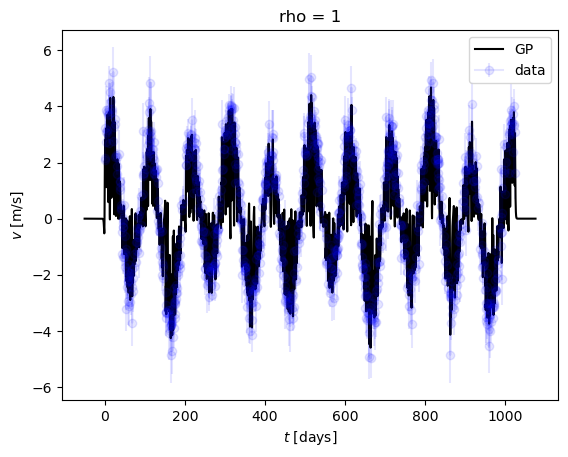

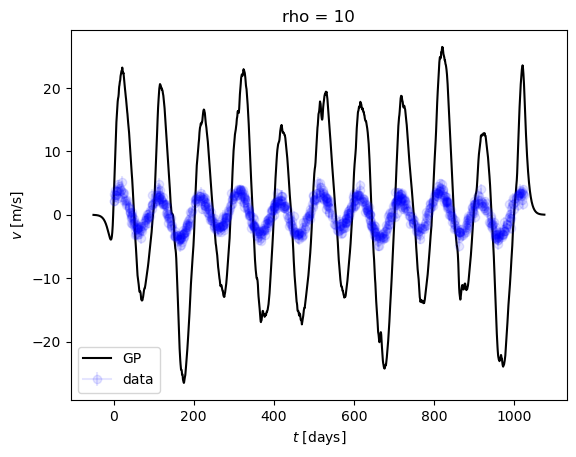

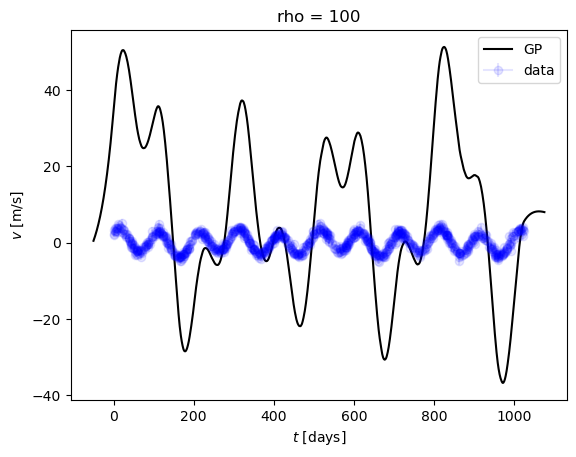

In [244]:
df = pd.read_pickle("data.pkl")     
X_data     = df[:,0]
Y_data_err = df[:,1]
Y_data     = df[:,12]

# Define the Matern 3/2 kernel
def kernel_matern_3halves(sig, d, rho):
    return sig**2 * (1 + np.sqrt(3) * d/rho) * np.exp(-np.sqrt(3*d*d)/rho) 

# Define Guassian Process Regression
def GP_regression(rho):
    # Training data and Test data
    X_test  = np.arange(-50, 1075, 0.1)
    Y_train = Y_data[:, np.newaxis]

    # Define C, K, K*
    C_dim   = X_data.shape[0]
    C_train = np.identity(C_dim)
    var     = [s**2 for s in Y_data_err]
    np.fill_diagonal(C_train, var)
    
    d       = np.subtract.outer(X_data, X_data)
    d_star  = np.subtract.outer(X_test, X_data)
    K       = kernel_matern_3halves(2, d, 1)
    K_star  = kernel_matern_3halves(2, d_star, rho)

    A       = np.linalg.solve(K+C_train, np.identity(C_dim))
    Y_test  = K_star @ A @ Y_train
    
    fig, ax = plt.subplots()
    ax.errorbar(X_data, Y_data, yerr = Y_data_err, marker = 'o', c = 'blue', alpha = 0.1, label = 'data')
    ax.plot(X_test, Y_test, c = 'black', label = 'GP')
    ax.set_title("rho = {}".format(rho))
    ax.set_xlabel(r'$t$ [days]')
    ax.set_ylabel(r'$v$ [m/s]')
    ax.legend()
    
GP_regression(1)
GP_regression(10)
GP_regression(100)